In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core'


nprocs = 20

In [3]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21374 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 21374 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 21374 tips and 21373 internal nodes ]


In [5]:
%%R
#Rarefy samples to 9500 seqs / sample
physeq.Bulk.r = rarefy_even_depth(physeq.Bulk, sample.size = 9500, rngseed = 23435, replace = TRUE,
                          trimOTUs = TRUE, verbose = TRUE)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: `set.seed(23435)` was used to initialize repeatable random subsampling.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Please record this for your records so others can reproduce.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Try `set.seed(23435); .Random.seed` for the full vector

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: ...

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 3228OTUs were removed because they are no longer 
present in any sample after random subsampling


  res = super

In [6]:
%%R
physeq.Bulk.m = physeq.Bulk.r %>% sample_data

physeq.Bulk.r.N = prune_samples((physeq.Bulk.m$Till == "N"),
                           physeq.Bulk.r)

physeq.Bulk.r.P = prune_samples((physeq.Bulk.m$Till == "P"),
                           physeq.Bulk.r)

print(physeq.Bulk.r.N)
print(physeq.Bulk.r.P)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 18146 taxa and 88 samples ]
sample_data() Sample Data:       [ 88 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 18146 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 18146 tips and 18145 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 18146 taxa and 88 samples ]
sample_data() Sample Data:       [ 88 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 18146 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 18146 tips and 18145 internal nodes ]


In [23]:
%%R
get_l2fc = function(physeq.obj, Month, Year, sparsity_threshold) {
    physeq.md = sample_data(physeq.obj)
  
  
    p = prune_samples((physeq.md$Month == Month) &
                      (physeq.md$Year == Year), physeq.obj)
   
    p = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ OM)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}

In [24]:
%%R

sdm.N = physeq.Bulk.r %>% sample_data %>% 
    filter(Till == 'N') %>%
    select(Month, Year) %>%
    distinct() %>%
    arrange(Year, Month) 

sdm.N %>% nrow %>% print
sdm.N %>% head(n=5)


[1] 11
      Month Year
1      July 2014
2  November 2014
3   October 2014
4 September 2014
5     April 2015


In [25]:
%%R

sdm.P = physeq.Bulk.r %>% sample_data %>% 
    filter(Till == 'P') %>%
    select(Month, Year) %>%
    distinct() %>%
    arrange(Year, Month) 

sdm.P %>% nrow %>% print
sdm.P %>% head(n=5)

[1] 11
      Month Year
1      July 2014
2  November 2014
3   October 2014
4 September 2014
5     April 2015


In [26]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms.N = sdm.N %>%
    unite(sdm.N, Month, Year, sep='___')

sdms.N = expand.grid(sdms.N$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Month', 'Year'), sep='___')


cat('Number of pairwise combinations of variables:', sdms.N %>% nrow, '\n\n')
head(sdms.N) 

Number of pairwise combinations of variables: 209 

      Month Year sparsity_threshold
1      July 2014               0.05
2  November 2014               0.05
3   October 2014               0.05
4 September 2014               0.05
5     April 2015               0.05
6    August 2015               0.05


In [27]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms.P = sdm.P %>%
    unite(sdm.P, Month, Year, sep='___')

sdms.P = expand.grid(sdms.P$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Month', 'Year'), sep='___')


cat('Number of pairwise combinations of variables:', sdms.P %>% nrow, '\n\n')
head(sdms.P) 

Number of pairwise combinations of variables: 209 

      Month Year sparsity_threshold
1      July 2014               0.05
2  November 2014               0.05
3   October 2014               0.05
4 September 2014               0.05
5     April 2015               0.05
6    August 2015               0.05


In [28]:
%%R
registerDoParallel(8)

df.l2fc.N = tbl_df(mdply(sdms.N, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk.r.N))
df.l2fc.N

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [502,880 x 15]

   Month  Year sparsity_threshold       OTU log2FoldChange     lfcSE      padj
   (chr) (chr)              (dbl)     (chr)          (dbl)     (dbl)     (dbl)
1   July  2014               0.05  OTU.4940    -0.87524472 1.2450302 0.7821754
2   July  2014               0.05  OTU.1739    -0.04216023 1.3085491 0.9997102
3   July  2014               0.05  OTU.1813    -0.97186458 1.3804423 0.7821754
4   July  2014               0.05   OTU.778     1.03067242 0.7250247 0.7821754
5   July  2014               0.05  OTU.5511    -0.86105988 1.2438457 0.7821754
6   July  2014               0.05 OTU.13088     1.61255382 1.3500593 0.7821754
7   July  2014               0.05  OTU.7376    -0.87007523 1.2446016 0.7821754
8   July  2014               0.05  OTU.8169    -1.18806054 1.2855149 0.7821754
9   July  2014               0.05 OTU.17812     0.80068714 1.2457153 0.7821754
10  July  2014               0.05  OTU.2180    -1.22036844 1.2925321 0.7821754
..   ...   

In [29]:
%%R
registerDoParallel(8)

df.l2fc.P = tbl_df(mdply(sdms.P, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk.r.P))
df.l2fc.P

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [519,621 x 15]

   Month  Year sparsity_threshold       OTU log2FoldChange     lfcSE      padj
   (chr) (chr)              (dbl)     (chr)          (dbl)     (dbl)     (dbl)
1   July  2014               0.05  OTU.4940     1.97616375 1.3721993 0.5499283
2   July  2014               0.05  OTU.1739     0.55156274 1.3614908 0.8587131
3   July  2014               0.05   OTU.778     0.66519813 0.9768921 0.7499443
4   July  2014               0.05  OTU.5658    -1.36228716 1.3721438 0.5499283
5   July  2014               0.05  OTU.5664    -1.36228716 1.3721438 0.5499283
6   July  2014               0.05  OTU.8169    -1.36238158 1.3721482 0.5499283
7   July  2014               0.05  OTU.6540     1.38577593 1.3720998 0.5499283
8   July  2014               0.05  OTU.2180    -0.00582319 1.2539596 0.9998338
9   July  2014               0.05  OTU.8236    -1.36228716 1.3721438 0.5499283
10  July  2014               0.05 OTU.12365     0.98953481 1.3294838 0.7095261
..   ...   

In [30]:
%%R
summarise(df.l2fc.N,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

     meanl2fc
        (dbl)
1 -0.04420861


In [31]:
%%R
summarise(df.l2fc.P,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

     meanl2fc
        (dbl)
1 0.004687854


In [32]:
%%R
summarise(df.l2fc.N,
  sdl2fc.N = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

   sdl2fc.N
      (dbl)
1 0.9558166


In [33]:
%%R
summarise(df.l2fc.P,
  sdl2fc.P = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

   sdl2fc.P
      (dbl)
1 0.8425707


In [34]:
%%R
levels(physeq.Bulk.m$OM)

[1] "H" "R"


In [35]:
%%R
df.l2fc.N$padj2 = p.adjust(df.l2fc.N$padj, method = "BH")

In [36]:
%%R
df.l2fc.P$padj2 = p.adjust(df.l2fc.P$padj, method = "BH")

In [37]:
%%R
df.l2fc.N$OM[df.l2fc.N$log2FoldChange > 0] = "Returned"
df.l2fc.N$OM[df.l2fc.N$log2FoldChange <0] = "Harvested"

In [38]:
%%R
df.l2fc.P$OM[df.l2fc.P$log2FoldChange > 0] = "Returned"
df.l2fc.P$OM[df.l2fc.P$log2FoldChange <0] = "Harvested"

In [39]:
%%R
df.l2fc$OM[df.l2fc$log2FoldChange > 0] = "Returned"
df.l2fc$OM[df.l2fc$log2FoldChange <0] = "Harvested"

In [40]:
%%R
write.table(df.l2fc.N, "data/l2fc_OM_N", row.names = FALSE, sep = ",")

In [41]:
%%R
write.table(df.l2fc.P, "data/l2fc_OM_P", row.names = FALSE, sep = ",")

In [42]:
%%R
df.l2fc.N = read.table("data/l2fc_OM_N", header = TRUE, sep = ",")

In [43]:
%%R
df.l2fc.P = read.table("data/l2fc_OM_P", header = TRUE, sep = ",")

In [44]:
%%R
N = filter(df.l2fc.N, padj2 <=0.10)
length(unique(N$OTU))

[1] 3


In [45]:
%%R
P = filter(df.l2fc.P, padj2 <=0.10)
length(unique(P$OTU))

[1] 0


In [46]:
%%R

padj.cutoff = 0.10

df.l2fc.N.rejH = df.l2fc.N %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold, Month, Year) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.N.rejH %>% head(n=6)

Source: local data frame [6 x 4]

  sparsity_threshold    Month  Year n_reject_hypo
               (dbl)   (fctr) (int)         (int)
1               0.05 November  2014             1
2               0.10 November  2014             1
3               0.15     July  2015             1
4               0.15 November  2014             1
5               0.20     July  2015             1
6               0.20 November  2014             1


In [47]:
%%R

padj.cutoff = 0.10

df.l2fc.P.rejH = df.l2fc.P %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold, Month, Year) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.P.rejH %>% head(n=6)

Source: local data frame [0 x 4]

Variables not shown: sparsity_threshold (dbl), Month (fctr), Year (int),
  n_reject_hypo (int)


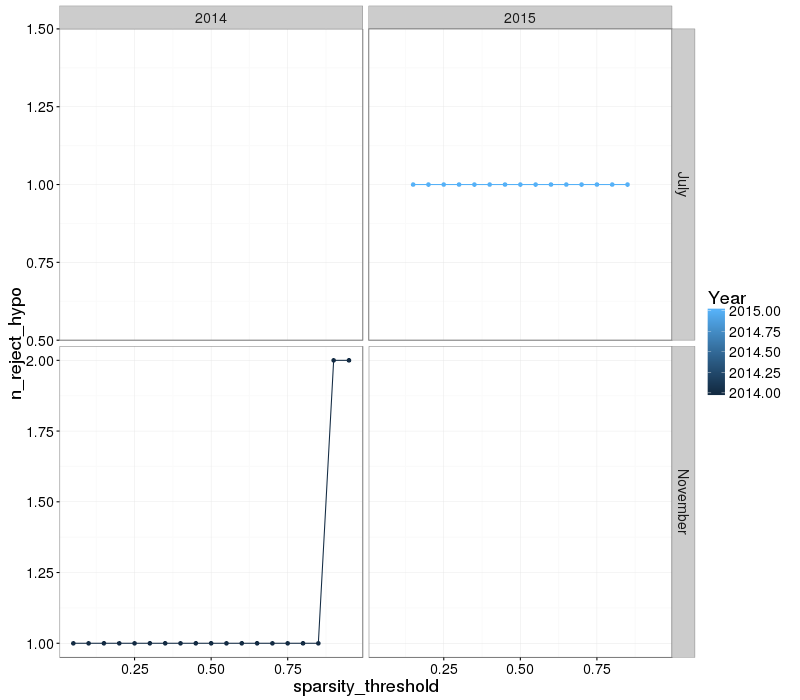

In [48]:
%%R -w 800 -h 700

df.l2fc.N.rejH$Month = reorder(df.l2fc.N.rejH$Month, df.l2fc.N.rejH$Month %>% as.numeric)

ggplot(df.l2fc.N.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(aes(color= Year)) +
    geom_line(aes(color = Year)) +
    facet_grid(Month ~ Year, scales = "free_y") +
    theme_bw() +
    theme(
        text = element_text(size=18)
        )

In [49]:
%%R -w 800 -h 700

df.l2fc.P.rejH$Month = reorder(df.l2fc.P.rejH$Month, df.l2fc.P.rejH$Month %>% as.numeric)

ggplot(df.l2fc.P.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(aes(color= Year)) +
    geom_line(aes(color = Year)) +
    facet_grid(Month ~ Year, scales = "free_y") +
    theme_bw() +
    theme(
        text = element_text(size=18)
        )

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error: Faceting variables must have at least one value

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)


RRuntimeError: Error: Faceting variables must have at least one value


In [ ]:
%%R

padj.cutoff = 0.1

N.rejH.s = df.l2fc.N %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

N.rejH.s %>% head(n=3) %>% as.data.frame

In [ ]:
%%R
# max number of rejected hypos 
max.N.rejH = N.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.N.rejH = max.N.rejH$sparsity_threshold
max.N.rejH

In [ ]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [ ]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == max.rejH) 

df.l2fc.f %>% nrow

In [ ]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_sparse-maxRejH_Bulk_OM.txt'
write.table(df.l2fc.f, 'data/l2fc_sparse-maxRejH_bulk_OM.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [ ]:
%%R
df.l2fc = read.table('data/l2fc_sparse-maxRejH_bulk_OM.txt', sep='\t', header = TRUE)

In [ ]:
%%R
df.l2fc$Month = factor(df.l2fc$Month, levels = c("April", "June", "July", "August", "September", "October", "November"))


In [ ]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.05) %>% group_by(Month, Year, OM) %>% summarise(resp = n())
resp %>% as.data.frame

In [ ]:
%%R -w 800 -h 600
p = ggplot(data = resp, aes(x = OM, y = resp, fill = OM)) +
    geom_bar(stat = 'identity') + facet_grid(Year~Month, scales = 'free_y')+
    theme(text = element_text(size=16)) + ylab("Number of Enriched OTUs") + scale_x_discrete(breaks=NULL)
p

In [ ]:
%%R
ggsave(filename = "data/figs/EnrichedNumoverTime.jpg", plot = p, width =12, height =6)

In [ ]:
%%R -w 800 -h 300
ggplot(data = resp, aes(x = OM, y = resp, fill = OM)) +
    geom_bar(stat = 'identity') + facet_grid(Year~Month) +
    theme(text = element_text(size=16))

####Function arguments

In [ ]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.05

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_grid(Year~Month)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= 0.05), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) #+ guides(color = FALSE)

p

In [ ]:
%%R
re = filter(df.l2fc, padj2 <=0.05)
length(unique(re$OTU))

In [ ]:
%%R
head(dcounts)

In [ ]:
%%R -w 800 -h 1000
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          filter(log2FoldChange > 0) %>%
          group_by(Rank2,Month) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 1)
dcounts$Rank2 <- droplevels(dcounts$Rank2) 
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)


p = ggplot(dcounts, aes(x = Month , y = responders, fill = Month)) +
    geom_bar(stat = "identity") + scale_x_discrete(breaks=NULL) +
    facet_wrap( ~ Rank2, ncol = 4, nrow = 7) + ggtitle("NT Responders")


p

In [ ]:
%%R -w 800 -h 1000
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          filter(log2FoldChange < 0) %>%
          group_by(Rank2,Month) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 0)
dcounts$Rank2 <- droplevels(dcounts$Rank2)
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = Month , y = responders, fill = Month)) +
    geom_bar(stat = "identity") + scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap( ~ Rank2, scales = "free_y", ncol = 4, nrow = 7) + ggtitle("PT Responders") + ylab("Responder Counts") 
    


p

In [ ]:
%%R
ggsave(filename = "figs/PT_byphyla.png", plot = p, width =6, height =8)

In [ ]:
%%R
dcounts$responders

In [ ]:
%%R 
 new_df.l2fc = df.l2fc %>% 
filter(!is.na(log2FoldChange)) %>% 
filter(!is.na(padj)) %>%
select(log2FoldChange, padj, OTU, Rank2, Month) 



In [ ]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = "non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange > 0] = "NT enriched"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 &  new_df.l2fc$log2FoldChange < 0] = "PT enriched"

In [ ]:
%%R
NT = filter(new_df.l2fc, Month == "November")
PT = filter(new_df.l2fc, Month == "November")
#length(unique(intersect(NT$OTU, PT$OTU)))
length((NT$OTU))

In [ ]:
%%R -w 1000 -h 500
dcounts = new_df.l2fc %>%
          #filter(!is.na(log2FoldChange)) %>%
          #filter(!is.na(padj)) %>%
          filter(Resp_status %in% c("NT enriched", "PT enriched")) %>%
          group_by(Rank2, Month, Resp_status) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, Rank2 %in% c("__Proteobacteria", "__Acidobacteria", "__Bacteroidetes", "__Planctomycetes", "__Chloroflexi", "__Actinobacteria", "__Verrucomicrobia", "__Gemmatimonadetes", "__Candidate_division_WS3", "__Cyanobacteria", "__Armatimonadetes", "__Firmicutes", "__Nitrospirae", "__Chlorobi"))
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)
newrow = c("__Firmicutes", "October", "PT enriched", as.numeric(0))
dcounts = rbind(dcounts,newrow)
newrow = c("__Armatimonadetes", "October", "PT enriched", 0)
dcounts = rbind(dcounts,newrow)
newrow = c("__Armatimonadetes", "November", "PT enriched", 0)
dcounts = rbind(dcounts,newrow)
newrow = c("__Cyanobacteria", "November", "PT enriched", 0)
dcounts = rbind(dcounts,newrow)
dcounts$Rank2 <- droplevels(dcounts$Rank2)
dcounts$responders= as.numeric(dcounts$responders)
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = Month , y = responders, fill = Resp_status)) +
    geom_bar(stat = "identity", position="dodge") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap( ~ Rank2, ncol = 5, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Month") + guides(fill=guide_legend(title="Month")) +
    theme(text = element_text(size=18), axis.text.x = element_text(angle=90, vjust=1), legend.position=c(.9, 0.2)) 


p

In [ ]:
%%R
ggsave(filename = "figs/PTvsNT_phyla_wmonths.png", plot = p, width =16, height =8)

In [ ]:
%%R -w 1000 -h 1000
dcounts = new_df.l2fc %>%
          #filter(!is.na(log2FoldChange)) %>%
          #filter(!is.na(padj)) %>%
          filter(Resp_status %in% c("NT enriched", "PT enriched")) %>%
          group_by(Rank2,Month, Resp_status) %>%
          summarize(responders = sum(padj<= 0.10))
#dcounts = filter(dcounts, responders >= 0)
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)
#dcounts$Rank2 <- droplevels(dcounts$Rank2)

p = ggplot(dcounts, aes(x = Resp_status , y = responders, fill = Resp_status)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap( ~ Rank2, ncol = 6, scales = "free_y") + ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Phyla") + guides(fill=guide_legend(title="Responder Status"))

p

In [ ]:
%%R
ggsave(filename = "figs/PTvsNT_phyla.png", plot = p, width =14, height =14)

In [ ]:
%%R
d = (filter(new_df.l2fc, Resp_status =="NT responder"))
length(d$OTU)
length(unique(d$OTU))

In [ ]:
%%R
e = (filter(new_df.l2fc, Resp_status =="PT responder"))
length(e$OTU)
length(unique(e$OTU))

In [ ]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

In [ ]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
p = p + facet_wrap(~Month)
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Phylum")
p

In [ ]:
%%R -w 1000 -h 400
new_df.l2fc_2 = filter(new_df.l2fc, padj <=0.10)
p = ggplot(new_df.l2fc_2, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
p = p + facet_wrap(~Month, ncol = 4)
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Phylum")
p

In [ ]:
%%R
ggsave(filename = "figs/NT_PT_phyla.png", plot = p, width =10, height =3)

In [ ]:
%%R -w 700 -h 700
July = filter(new_df.l2fc, Month == "July") %>%
        group_by(OTU) 
Sept = filter(new_df.l2fc, Month == "September")%>%
        group_by(OTU)
JS2 = right_join(July, Sept, by = "OTU")

In [ ]:
%%R
JS2$Resp_status[JS2$padj.x > 0.10 & JS2$padj.y >0.10] = "unknown/non-responder"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x > 0 & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y > 0] = "NT responder both"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x < 0 & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y < 0] = "PT responder both"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x < 0 & JS2$padj.y > 0.10] = "PT responder July"
JS2$Resp_status[JS2$padj.x > 0.10  & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y < 0] = "PT responder Sept"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x > 0 & JS2$padj.y > 0.10] = "NT responder July"
JS2$Resp_status[JS2$padj.x > 0.10  & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y > 0] = "NT responder Sept"

In [ ]:
%%R
head(JS2)

In [ ]:
%%R -w 600 -h 600
p = ggplot(JS2, aes(log2FoldChange.x, log2FoldChange.y))
p = p + geom_point(aes(color = Resp_status))
p = p + xlab("July log2-fold change") + ylab("September log2-fold change")
p = p + scale_colour_discrete(name="Responder Status")
p = p + theme(text=element_text(size = 20))
p

In [ ]:
%%R
Sept = filter(new_df.l2fc, Month == "September") %>%
        group_by(OTU) 
Oct = filter(new_df.l2fc, Month == "October")%>%
        group_by(OTU)
SO = right_join(Sept, Oct, by = "OTU")

In [ ]:
%%R
SO$Resp_status[SO$padj.x > 0.10 & SO$padj.y >0.10] = "unknown/non-responder"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x > 0 & SO$padj.y <= 0.10 & SO$log2FoldChange.y > 0] = "NT responder both"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x < 0 & SO$padj.y <= 0.10 & SO$log2FoldChange.y < 0] = "PT responder both"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x < 0 & SO$padj.y > 0.10] = "PT responder Sept"
SO$Resp_status[SO$padj.x > 0.10  & SO$padj.y <= 0.10 & SO$log2FoldChange.y < 0] = "PT responder Oct"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x > 0 & SO$padj.y > 0.10] = "NT responder Sept"
SO$Resp_status[SO$padj.x > 0.10  & SO$padj.y <= 0.10 & SO$log2FoldChange.y > 0] = "NT responder Oct"

In [ ]:
%%R -w 600 -h 600
p = ggplot(SO, aes(log2FoldChange.x, log2FoldChange.y))
p = p + geom_point(aes(color = Resp_status))
p = p + xlab("July log2-fold change") + ylab("September log2-fold change")
p = p + scale_colour_discrete(name="Responder Status")
p = p + theme(text=element_text(size = 20))
p

## Blasting against Living Tree Project db

In [ ]:
from Bio.Blast.Applications import NcbiblastnCommandline as blast

In [ ]:
from cogent import LoadSeqs, DNA


In [ ]:
OTU_ids = ["OTU.162", "OTU.239", "OTU.2456", "OTU.256", "OTU.3194", "OTU.80"]
seqs = LoadSeqs("/home/chantal/RNASIP/data/totalRNA.otusn.fasta", moltype=DNA, aligned=False)
seqs = seqs.takeSeqs(OTU_ids).toFasta()
print seqs

In [ ]:
my_file = open("seqs.fasta", "w")
my_file.write(seqs)
my_file.close()

In [ ]:
cline = blast(query = "seqs.fasta",
              db = "/var/seq_data/silva/silva_blastdb/silva_RefNR_115",
              outfmt = 6,
              out = "otusn_silvaRefNR115.m6",
              num_threads = 5)
print cline
cline()

In [ ]:
!head -n1 otusn_silvaRefNR115.m6
!wc -l otusn_silvaRefNR115.m6
! grep -c "OTU.80" otusn_silvaRefNR115.m6

In [ ]:
from IPython.display import Image
import pandas.rpy.common as com

In [ ]:
%%R
library(data.table)
library(dplyr)

In [ ]:
%%R
blastout_dt = fread("otusn_silvaRefNR115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %>% 
                          group_by(OTU) %>% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) %>% 
                          filter(pid > 97.0) %>%
                          filter(e.value < 5.0e-180) %>%
                          filter(acc %in% c('AM286414', 'AB428568', 'EU877263', 'EF575565', 'EF494193', 'X82449'))

In [ ]:
%%R
print(head(top_hits_df_LTP))
str(top_hits_df_LTP$OTU)

In [ ]:
%%R
dt = fread("/var/seq_data/LTP115_db/LTPs115_SSU.csv", sep = ";")
colnames(dt) = c("acc","start","end","DB.version","name","unknown1","family","unknown2","url","full_tax")
LTP_seq_data = tbl_df(dt)

In [ ]:
%%R
joined_df = left_join(top_hits_df_LTP, LTP_seq_data)

In [ ]:
%%R
joined_df = filter(joined_df, name != "NA")

In [ ]:
%%R
dim(joined_df)

In [ ]:
df = com.load_data("joined_df")

In [ ]:
def get_latex(df):
    latex = ""
    prefix = r"\multirow{%s}{*}{%s}"%(len(df.index), df.OTU.iloc[0])
    for i, r in df[["name","pid","acc"]].iterrows():
        latex += " & " + " & ".join([str(i) for i in r.values]) + r" \\ "
    return prefix + latex + r"\midrule" + "\n"

In [ ]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{13}$C RNA responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{l>{\itshape}lrl}
    \toprule \\
    \textbf{OTU ID} & \textbf{Species Name} & \textbf{BLAST percent identity} & \textbf{accession} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("../data/tmp/table.tex", "w") as out:
    out.write(table_framework)

In [ ]:
!latex -output-directory="../data/tmp" ../data/tmp/table.tex >/dev/null 2>&1 && \
dvipng -o ../data/table.png ../data/tmp/table.dvi >/dev/null 2>&1
Image("../data/table.png")